In [8]:
# Load relevant modules
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# Define the state vector by specifying P0 and V0
# Some different P0 - initial positions
P01=[ 6100, 4500, 0]
P02=[-2.3351e4, -2.1746e4, -2.1316e3]

# Some different V0 - initial velocities
V01=[ 2.9268, -0.1393, -0.0792]
V02=[ 2.9268, -1.1393, -0.0792]
V03=[ 0,  8, 3.8]
V04=[-2.7874, 2.6403, 0]

# Some state vectors, try different combinations of P0 and V0
X01 = np.array([P01, V01])
X02 = np.array([P02, V02])

In order to update the orbit, we need to solve an initial value problem (compared to the Matlab code we need to imitate the function _ode45_ ). There are various Python functions that can be used for this. Here, we compare scipy's _odeint_ and _solve_ivp_ functions. 

Sources: 
https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python
https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/

In [10]:
def update_orbit(t, X):
    """
        Function to update the orbit with. 
        MU is the standard gravitational parameter:
            MU = G * M, where 
            M = M_Earth = 5.97×10^{24} kg
            G = 6.67×10^{−11} m3⋅kg−1⋅s−2
        
        The change in velocity dV = -mu * P / norm(P)^3.
        
        Using flatten() on the final state vector seems 
        to be necessary for the scipy functions to work.
    """
    MU = 398600    #units: km^3 s^{-2}
    P = X[0:3]     #P-part of the state vector X
    V = X[3:]      #V-part of the state vector X
    
    dP = V
    dV = -MU / (np.linalg.norm(P,2)**3) * P
    return np.array([dP,dV]).flatten()

# Now, use solve_ivp and odeint to update the orbits
# for given time intervals and starting conditions. 
# Note that solve_ivp somehow defines its own time-step.
#
# For the second orbit (different initial conditions),
# make the time longer to get a full orbit.

# SOLVE_IVP
t_start = 0.
t_final = 3600.

solivp1 = solve_ivp(update_orbit, [t_start, t_final], X01.flatten())
solivp2 = solve_ivp(update_orbit, [t_start, t_final*10.], X02.flatten())

# ODEINT
t_step = 10.
tspan = np.arange(t_start, t_final, t_step)

solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True)
solode2 = odeint(update_orbit, X02.flatten(), tspan*10, tfirst=True)

The arrays solivp1 and solode1 give the P and V for orbit 1 for the given time span, and solivp2 and solode2 give the P and V for orbit 2 for its time span. Note that the order of the arguments is switched between the functions! (solivp: specify [i, :], solode: specify [:, i], i = 0,1,2)

Below is some code to visualise the orbits. We're plotting the solutions for the three components of P for both of the orbits to compare between them. You can separate them, plot the V components or do whatever. 

It is also possible to produce an animation of the orbit by updating the plot at each time step; it would then be nice to add a perturbation after a certain time to see the change in orbit. If I feel like procrastinating, I will write the code.

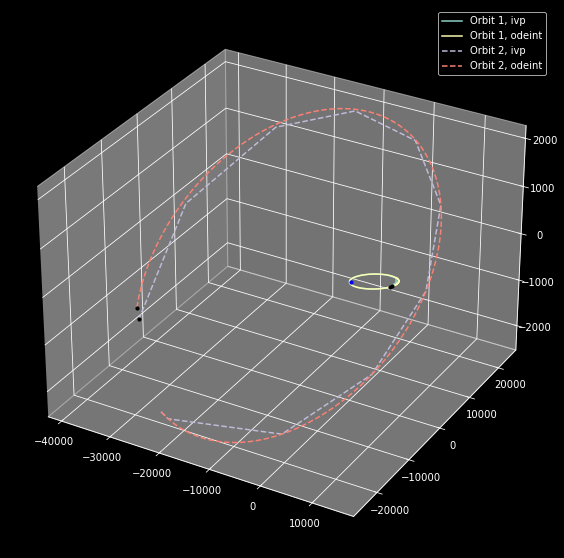

In [11]:
%matplotlib inline
# Set a dark background... since... space is dark.
plt.style.use('dark_background')

FIG = plt.figure(figsize=(10,10))
AX = FIG.add_subplot(1,1,1, projection='3d')

# Create a blue dot that represents the Earth, add it to the ax
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1
AX.plot(solivp1.y[0, :], solivp1.y[1, :], solivp1.y[2, :], label='Orbit 1, ivp')
AX.scatter(solivp1.y[0, -1], solivp1.y[1,-1], solivp1.y[2,-1],c='k',s=10)

AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 2
AX.plot(solivp2.y[0, :], solivp2.y[1, :], solivp2.y[2, :], linestyle='--', label='Orbit 2, ivp')#T1, Y1[0,:])
AX.scatter(solivp2.y[0, -1], solivp2.y[1,-1], solivp2.y[2,-1],c='k',s=10)

AX.plot(solode2[:, 0], solode2[:, 1], solode2[:, 2], linestyle='--', label='Orbit 2, odeint')
AX.scatter(solode2[-1,0], solode2[-1,1], solode2[-1,2],c='k',s=10)

# Configuring the plot
#AX.set_aspect("equal")
AX.legend()

plt.show()

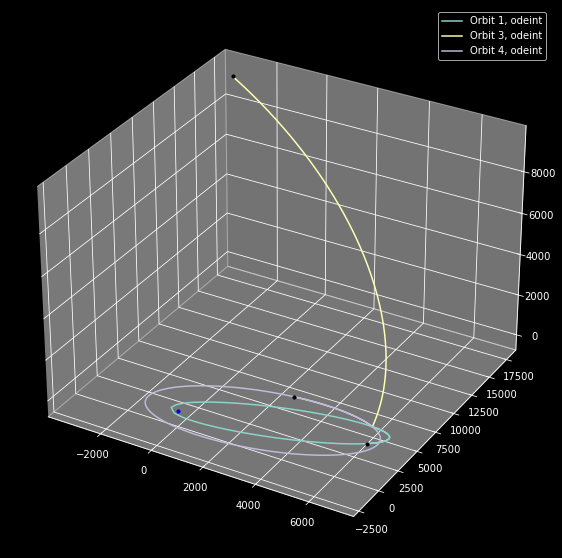

In [12]:
# Make two orbits with the same P0 but different V0 using ODEINT.
# You can see from the plot that they travel different distances
# in the same time. 
X03 = np.array([P01, V03])
X04 = np.array([P01, V04])

solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True)
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True)

# Plotting
FIG2 = plt.figure(figsize=(10,10))
AX = FIG2.add_subplot(1,1,1, projection='3d')
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1 (re-used from above)
AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 3
AX.plot(solode3[:, 0], solode3[:, 1], solode3[:, 2], label='Orbit 3, odeint')
AX.scatter(solode3[-1,0], solode3[-1,1], solode3[-1,2],c='k',s=10)

# Orbit 4
AX.plot(solode4[:, 0], solode4[:, 1], solode4[:, 2], label='Orbit 4, odeint')
AX.scatter(solode4[-1,0], solode4[-1,1], solode4[-1,2],c='k',s=10)

AX.legend()
plt.show()


<IPython.core.display.Javascript object>


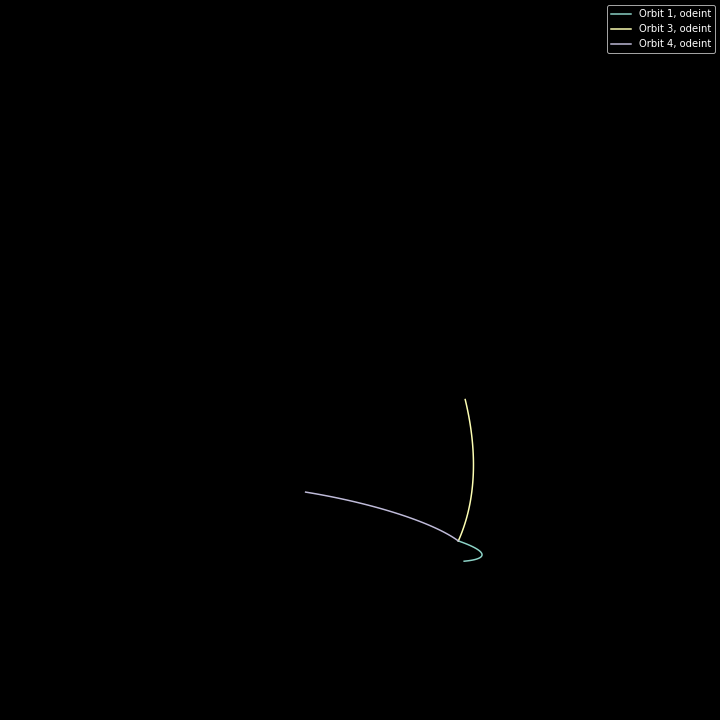

/tmp/ipykernel_26408/3451993214.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  AX = Axes3D(FIG3)


In [26]:
#This is all nice but let's animate this same plot
#change the matplotlib engine
%matplotlib notebook
#for some reason it needs to be transposed for the animation to work
solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True).transpose()
solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True).transpose()
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True).transpose()

#initialise the figure
FIG3 = plt.figure(figsize=(10,10))
AX = Axes3D(FIG3)

#initialise the plots (they can no be empty in 3D)
orbitPlots = [AX.plot(solode1[0, 0:1], solode1[1, 0:1], solode1[2, 0:1], label='Orbit 1, odeint')[0], AX.plot(solode3[0, 0:1], solode3[1, 0:1], solode3[2, 0:1], label='Orbit 3, odeint')[0], AX.plot(solode4[0, 0:1], solode4[1, 0:1], solode4[2, 0:1], label='Orbit 4, odeint')[0]]
orbitData = [solode1,solode3,solode4]

#Make a function that will be called to update every frame
def animate(i, data, plots):
    if i==0:
        return plots
    else:
        for plot, dat in zip(plots, data):
            plot.set_data(dat[0:2,:i])
            plot.set_3d_properties(dat[2,:i])
        return plots

# Setting the axes properties
AX.axis("off")
AX.set_xlim3d([-3000, 8000])

AX.set_ylim3d([-3000, 20000])

AX.set_zlim3d([-1000, 10000])

AX.set_title('3D Test')
AX.legend()

#Call the magic function that makes the animation
animation = FuncAnimation(FIG3, animate, fargs=(orbitData, orbitPlots), frames=range(len(solode3[0,:])), interval=10, repeat=True, blit=False)
plt.show()

